# Import libraries

In [1]:
# Import libraries
# Module imports
%matplotlib inline
import matplotlib.pylab as plt

#from utils.helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import math
import copy
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc, accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR



# Some base models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import ParameterGrid
from sklearn import preprocessing
from sklearn.cluster import KMeans
import xgboost as xgb

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

import pickle


# set seed
SEED=3642
np.random.seed(SEED)



from sklearn.metrics import mean_squared_error, r2_score
import fbprophet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.metrics import mean_absolute_error

[MLENS] backend: threading


# Data preprocessing

## Read in data

In [2]:
dataset = pd.read_csv("./DW_BI_project/modelling_dataset.csv")

# Some data cleaning
dataset = dataset.drop(columns = ["Unnamed: 0"])
dataset = dataset.drop_duplicates(subset=['city', 'time'], keep='last')

print(dataset.shape)
print(dataset.columns)
print(dataset.head())

(2053, 22)
Index(['city', 'time', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'w', 'p', 't',
       'temperature', 'pressure', 'humidity', 'temp_min', 'temp_max', 'cloud',
       'wind_speed', 'wind_degree', 'longitude', 'latitude', 'accident_num'],
      dtype='object')
         city                 time    co   no2    o3  pm10  pm25  so2    w  \
16    Beijing  2019-11-22 19:00:00  19.9  48.9   0.5   117   196  4.6  0.5   
32   Budapest  2019-11-22 11:00:00   5.8  19.3   4.7    20    94  3.7  1.2   
34      Tokyo  2019-11-22 20:00:00   5.6  26.9  16.0     8     1  1.5  0.0   
100   Beijing  2019-11-22 20:00:00  21.7  49.9   0.9   109   204  4.6  0.5   
101  Budapest  2019-11-22 12:00:00   5.4  20.2   6.7    18    94  4.1  0.8   

          p  ...  pressure  humidity  temp_min  temp_max  cloud  wind_speed  \
16      0.0  ...    1020.0      75.0    279.26    282.04   69.0         1.0   
32   1018.1  ...    1017.0      71.0    284.15    284.82   77.0         5.7   
34   1029.1  ...    1029

## Handle missing values

In [3]:
dataset.isna().sum() # We see that the big problem is with accident_num we will handle that

city              0
time              0
co                0
no2               0
o3                0
pm10              0
pm25              0
so2               0
w                 0
p                 0
t                 0
temperature      20
pressure         20
humidity         20
temp_min         20
temp_max         20
cloud            20
wind_speed       20
wind_degree      20
longitude        20
latitude         20
accident_num    895
dtype: int64

In [4]:
# Number of accidents
dataset['accident_num'].fillna(dataset.groupby('city')['accident_num'].transform("median"), inplace=True)

In [5]:
# After the imputation we drop the observations with missing data
dataset = dataset.dropna()
print(dataset.shape)
print(dataset.isna().sum())

(1158, 22)
city            0
time            0
co              0
no2             0
o3              0
pm10            0
pm25            0
so2             0
w               0
p               0
t               0
temperature     0
pressure        0
humidity        0
temp_min        0
temp_max        0
cloud           0
wind_speed      0
wind_degree     0
longitude       0
latitude        0
accident_num    0
dtype: int64


In [6]:
# Sort dataset by city and time
dataset = dataset.sort_values(by=['city', 'time'])
print(dataset.head())

         city                 time   co   no2   o3  pm10  pm25  so2    w  \
32   Budapest  2019-11-22 11:00:00  5.8  19.3  4.7    20    94  3.7  1.2   
101  Budapest  2019-11-22 12:00:00  5.4  20.2  6.7    18    94  4.1  0.8   
124  Budapest  2019-11-22 13:00:00  5.3  15.3  7.4    12    94  4.3  0.8   
147  Budapest  2019-11-22 14:00:00  5.8  16.1  7.5    15    94  5.0  0.6   
155  Budapest  2019-11-22 15:00:00  5.8  19.6  5.6    24    94  5.0  0.2   

          p  ...  pressure  humidity  temp_min  temp_max  cloud  wind_speed  \
32   1018.1  ...    1017.0      71.0    284.15    284.82   77.0         5.7   
101  1017.6  ...    1016.0      62.0    284.26    285.37   93.0         5.7   
124  1017.1  ...    1016.0      71.0    283.71    284.82   40.0         5.7   
147  1017.3  ...    1017.0      71.0    282.59    284.26   75.0         4.1   
155  1017.6  ...    1017.0      76.0    282.59    284.26   75.0         4.6   

     wind_degree  longitude  latitude  accident_num  
32         130

In [7]:
# Copy current dataset to be used for prediction later
pred_table = dataset.copy()

## Lag creators

In [8]:
def lag_creators(num_lags,target_var,dataset):
    
    for i in range(5,num_lags+1):
        temp = 'lag_hour_{}_{}'.format(i,target_var)
        temp_series = dataset.groupby('city')[target_var]
        dataset[temp] = temp_series.shift(periods = i)
        
    return dataset

In [9]:
dataset = lag_creators(8,'co',dataset)
print(dataset.head())

         city                 time   co   no2   o3  pm10  pm25  so2    w  \
32   Budapest  2019-11-22 11:00:00  5.8  19.3  4.7    20    94  3.7  1.2   
101  Budapest  2019-11-22 12:00:00  5.4  20.2  6.7    18    94  4.1  0.8   
124  Budapest  2019-11-22 13:00:00  5.3  15.3  7.4    12    94  4.3  0.8   
147  Budapest  2019-11-22 14:00:00  5.8  16.1  7.5    15    94  5.0  0.6   
155  Budapest  2019-11-22 15:00:00  5.8  19.6  5.6    24    94  5.0  0.2   

          p  ...  cloud  wind_speed  wind_degree  longitude  latitude  \
32   1018.1  ...   77.0         5.7        130.0      19.04      47.5   
101  1017.6  ...   93.0         5.7        120.0      19.04      47.5   
124  1017.1  ...   40.0         5.7        120.0      19.04      47.5   
147  1017.3  ...   75.0         4.1        130.0      19.04      47.5   
155  1017.6  ...   75.0         4.6        130.0      19.04      47.5   

     accident_num  lag_hour_5_co  lag_hour_6_co  lag_hour_7_co  lag_hour_8_co  
32          191.0       

In [10]:
# Other lags
dataset = lag_creators(8,'accident_num',dataset)
#print(dataset.head())

In [11]:
# Other lags
dataset = lag_creators(8,'wind_speed',dataset)
#print(dataset.head())

In [12]:
lag_cols = [i for i in dataset.columns if 'lag' in i]
print(lag_cols)

['lag_hour_5_co', 'lag_hour_6_co', 'lag_hour_7_co', 'lag_hour_8_co', 'lag_hour_5_accident_num', 'lag_hour_6_accident_num', 'lag_hour_7_accident_num', 'lag_hour_8_accident_num', 'lag_hour_5_wind_speed', 'lag_hour_6_wind_speed', 'lag_hour_7_wind_speed', 'lag_hour_8_wind_speed']


# Modelling

In [13]:
# Burn NaN-s from lag-generation
dataset = dataset.dropna()

print(dataset.shape)

(1118, 34)


## CO model

In [14]:
# Features
modelling_table = dataset[lag_cols]
print(modelling_table.head())

     lag_hour_5_co  lag_hour_6_co  lag_hour_7_co  lag_hour_8_co  \
187            5.8            5.3            5.4            5.8   
195            5.8            5.8            5.3            5.4   
203            6.7            5.8            5.8            5.3   
211            6.3            6.7            5.8            5.8   
219            6.8            6.3            6.7            5.8   

     lag_hour_5_accident_num  lag_hour_6_accident_num  \
187                    200.0                    200.0   
195                    200.0                    200.0   
203                    199.0                    200.0   
211                    198.0                    199.0   
219                    197.0                    198.0   

     lag_hour_7_accident_num  lag_hour_8_accident_num  lag_hour_5_wind_speed  \
187                    199.0                    191.0                    4.1   
195                    200.0                    199.0                    4.6   
203           

In [15]:
# Target variable
y = dataset['co']
X = modelling_table.copy()

In [16]:
xgb1 = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 6,
                                  min_child_weight= 11, missing= -999, n_estimators= 70,
                                  nthread= 1, objective= 'reg:squarederror', reg_lambda= 5,
                                  seed= 1337, silent= 1, subsample= 0.8)

xgb1.fit(X,y)

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=11, missing=-999, n_estimators=70,
             n_jobs=1, nthread=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=5, scale_pos_weight=1, seed=1337, silent=1,
             subsample=0.8, verbosity=1)

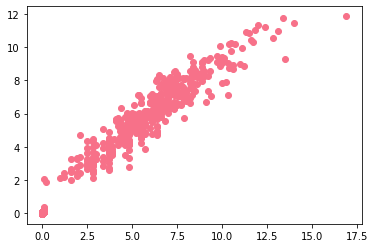

R^2 score is 0.9709678527371457


In [17]:
y_pred = xgb1.predict(X)
plt.scatter(y,y_pred)
plt.show()

print("R^2 score is {}".format(r2_score(y, y_pred)))

In [20]:
# Save model
filename = './xgb_model.sav'
pickle.dump(xgb1, open(filename, 'wb'))

# Save columns for modelling
filename = './model_cols.sav'
pickle.dump(lag_cols, open(filename, 'wb'))

# Predicting

In [24]:
print(pred_table.shape)
pred_table.head()

(812, 28)


,city,time,co,no2,o3,pm10,pm25,so2,w,p,...,wind_degree,longitude,latitude,accident_num,lag_hour_5_co,lag_hour_6_co,lag_hour_7_co,lag_hour_8_co,lag_hour_5_accident_num,lag_hour_5_wind_speed
32,Budapest,2019-11-22 11:00:00,5.8,19.3,4.7,20,94,3.7,1.2,1018.1,...,130.0,19.04,47.5,191.0,NaN,NaN,NaN,NaN,NaN,NaN
101,Budapest,2019-11-22 12:00:00,5.4,20.2,6.7,18,94,4.1,0.8,1017.6,...,120.0,19.04,47.5,199.0,NaN,NaN,NaN,NaN,NaN,NaN
124,Budapest,2019-11-22 13:00:00,5.3,15.3,7.4,12,94,4.3,0.8,1017.1,...,120.0,19.04,47.5,200.0,NaN,NaN,NaN,NaN,NaN,NaN
147,Budapest,2019-11-22 14:00:00,5.8,16.1,7.5,15,94,5.0,0.6,1017.3,...,130.0,19.04,47.5,200.0,NaN,NaN,NaN,NaN,NaN,NaN
155,Budapest,2019-11-22 15:00:00,5.8,19.6,5.6,24,94,5.0,0.2,1017.6,...,130.0,19.04,47.5,200.0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
pred_table2 = pred_table.copy()
print(pred_table2.shape)

pred_table2['time'] =  pd.to_datetime(pred_table2['time'], format='%Y-%m-%d %H:%M:%S')
#print(pred_table2.dtypes)
pred_table2 = pred_table2.reset_index(drop=True)

unique_city_names = pred_table2.city.nunique()
lags = 8

# Dummy, indicator column
pred_table2['forecast'] = 0

# Always the last 3 (number of lags) for each city is the prediction!
def add_row(x,lags):
    for i in range(0,lags):
        last_row = x.iloc[-1]
        last_time = last_row.time
        last_row['time'] = last_time + pd.DateOffset(hours=1)
        x = x.append(last_row)
        x.iloc[-1,-1] = 1
    return x


pred_table2 = pred_table2.groupby('city').apply(add_row, lags=5).reset_index(drop=True)
print(pred_table2.shape)
#print(pred_table2)

(812, 28)
(837, 29)


## Data preprocessing for prediction points

In [27]:
pred_table3 = pred_table2.copy()
pred_table3 = lag_creators(8,'co',pred_table3)
pred_table3 = lag_creators(8,'accident_num',pred_table3)
pred_table3 = lag_creators(8,'wind_speed',pred_table3)

pred_table4 = pred_table3[pred_table3.forecast==1]
pred_table4 = pred_table4.dropna()

pred_features = pred_table4[lag_cols]





## Running the model on the prediction points

25


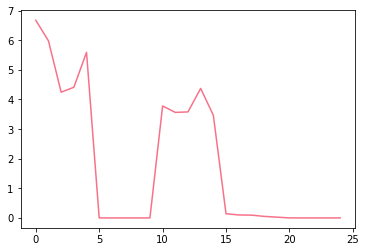

In [28]:
y_forecast = xgb1.predict(pred_features)
print(len(y_forecast))
plt.plot(y_forecast)
plt.show()

## Inserting prediction values back to the dashboard table

In [29]:
j=0
for i in range(0,pred_table2.shape[0]):

    if pred_table2.iloc[i,-1]==1:
        pred_table2.iloc[i,2]=y_forecast[j]
        #print(pred_table2.iloc[i,:])
        j = j+1
        
#print(pred_table2)

In [30]:
temp = pred_table2[pred_table2.forecast==1]
print(temp)

          city                time        co   no2    o3  pm10  pm25  so2  \
204   Budapest 2019-12-02 18:00:00  6.679191  14.0  11.5    28    94  3.9   
205   Budapest 2019-12-02 19:00:00  5.980814  14.0  11.5    28    94  3.9   
206   Budapest 2019-12-02 20:00:00  4.247881  14.0  11.5    28    94  3.9   
207   Budapest 2019-12-02 21:00:00  4.412466  14.0  11.5    28    94  3.9   
208   Budapest 2019-12-02 22:00:00  5.594057  14.0  11.5    28    94  3.9   
393   Dortmund 2019-12-02 18:00:00 -0.003237  32.5   0.9    31     0  2.6   
394   Dortmund 2019-12-02 19:00:00 -0.003237  32.5   0.9    31     0  2.6   
395   Dortmund 2019-12-02 20:00:00 -0.002986  32.5   0.9    31     0  2.6   
396   Dortmund 2019-12-02 21:00:00 -0.003237  32.5   0.9    31     0  2.6   
397   Dortmund 2019-12-02 22:00:00 -0.003237  32.5   0.9    31     0  2.6   
565     Moscow 2019-12-02 19:00:00  3.781887  16.4   8.9    23    17  1.0   
566     Moscow 2019-12-02 20:00:00  3.563698  16.4   8.9    23    17  1.0   

# Support (Work in Progress)

In [41]:
pred_table2.city.nunique()

5

In [51]:
print(max(dataset.time))

pred_table2[pred_table2.city=='Budapest'].head(-5)

2019-12-02 18:00:00


,city,time,co,no2,o3,pm10,pm25,so2,w,p,...,pressure,humidity,temp_min,temp_max,cloud,wind_speed,wind_degree,longitude,latitude,accident_num
0,Budapest,2019-11-22 11:00:00,5.8,19.3,4.7,20,94,3.7,1.2,1018.1,...,1017.0,71.0,284.15,284.82,77.0,5.7,130.0,19.04,47.5,191.0
1,Budapest,2019-11-22 12:00:00,5.4,20.2,6.7,18,94,4.1,0.8,1017.6,...,1016.0,62.0,284.26,285.37,93.0,5.7,120.0,19.04,47.5,199.0
2,Budapest,2019-11-22 13:00:00,5.3,15.3,7.4,12,94,4.3,0.8,1017.1,...,1016.0,71.0,283.71,284.82,40.0,5.7,120.0,19.04,47.5,200.0
3,Budapest,2019-11-22 14:00:00,5.8,16.1,7.5,15,94,5.0,0.6,1017.3,...,1017.0,71.0,282.59,284.26,75.0,4.1,130.0,19.04,47.5,200.0
4,Budapest,2019-11-22 15:00:00,5.8,19.6,5.6,24,94,5.0,0.2,1017.6,...,1017.0,76.0,282.59,284.26,75.0,4.6,130.0,19.04,47.5,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Budapest,2019-12-02 11:00:00,6.3,17.4,6.1,17,94,3.7,0.2,1018.3,...,1017.0,100.0,273.15,274.26,90.0,3.1,330.0,19.04,47.5,184.0
198,Budapest,2019-12-02 12:00:00,6.1,15.6,7.6,19,94,3.6,0.2,1018.6,...,1018.0,100.0,273.15,274.26,90.0,4.1,330.0,19.04,47.5,183.0
199,Budapest,2019-12-02 13:00:00,6.3,17.3,7.8,24,94,4.2,0.2,1018.9,...,1018.0,92.0,273.15,274.26,90.0,3.6,320.0,19.04,47.5,184.0
200,Budapest,2019-12-02 14:00:00,6.5,16.8,6.9,23,94,3.9,1.7,1019.4,...,1019.0,92.0,273.15,274.26,40.0,3.1,310.0,19.04,47.5,185.0


In [52]:
pred_table[pred_table.city=='Budapest'].head(-5)

,city,time,co,no2,o3,pm10,pm25,so2,w,p,...,pressure,humidity,temp_min,temp_max,cloud,wind_speed,wind_degree,longitude,latitude,accident_num
32,Budapest,2019-11-22 11:00:00,5.8,19.3,4.7,20,94,3.7,1.2,1018.1,...,1017.0,71.0,284.15,284.82,77.0,5.70,130.0,19.04,47.5,191.0
101,Budapest,2019-11-22 12:00:00,5.4,20.2,6.7,18,94,4.1,0.8,1017.6,...,1016.0,62.0,284.26,285.37,93.0,5.70,120.0,19.04,47.5,199.0
124,Budapest,2019-11-22 13:00:00,5.3,15.3,7.4,12,94,4.3,0.8,1017.1,...,1016.0,71.0,283.71,284.82,40.0,5.70,120.0,19.04,47.5,200.0
147,Budapest,2019-11-22 14:00:00,5.8,16.1,7.5,15,94,5.0,0.6,1017.3,...,1017.0,71.0,282.59,284.26,75.0,4.10,130.0,19.04,47.5,200.0
155,Budapest,2019-11-22 15:00:00,5.8,19.6,5.6,24,94,5.0,0.2,1017.6,...,1017.0,76.0,282.59,284.26,75.0,4.60,130.0,19.04,47.5,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,Budapest,2019-12-02 07:00:00,6.6,22.6,3.0,14,94,3.9,0.2,1018.4,...,1017.0,100.0,273.15,273.71,90.0,1.00,30.0,19.04,47.5,188.0
1868,Budapest,2019-12-02 08:00:00,7.5,25.4,1.6,16,94,4.1,0.2,1018.3,...,1017.0,100.0,273.15,273.71,90.0,1.50,80.0,19.04,47.5,191.0
1884,Budapest,2019-12-02 09:00:00,7.7,26.3,1.4,22,94,4.6,0.2,1018.3,...,1018.0,91.0,273.71,273.71,100.0,1.74,30.0,19.04,47.5,188.0
1892,Budapest,2019-12-02 11:00:00,6.3,17.4,6.1,17,94,3.7,0.2,1018.3,...,1017.0,100.0,273.15,274.26,90.0,3.10,330.0,19.04,47.5,184.0
